In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import PreProcessor, DataSet, DataSetNump
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [2]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("KO")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for HAR (realized daily/weekly/monthly volatility)
features_har = np.zeros(shape=(len(targets), 3))
features_har[:, 0] = targets.shift(1).values
features_har[:, 1] = targets.rolling(5).apply(np.mean).shift(1).values
features_har[:, 2] = targets.rolling(21).apply(np.mean).shift(1).values

    
# # features and targets to numpy array
features_har = features_har
features = features_har.copy() # or df.values # HAR and NN same input features
targets = targets.values.reshape(-1,1)

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

# remove the first few observations due to no estimation for monthly volatility available
start_index = 22
features_har = features_har[start_index:]
features = features[start_index:]
targets = targets[start_index:]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .6
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)

# # for model specification and final estimation
# features, features_har, targets
# # for model comparison
# features_validation, features_har_validation, targets_validation

Total observations: 15367
shape har featurs: (15345, 4) of type <class 'numpy.ndarray'>
shape nn features: (15345, 3) of type <class 'numpy.ndarray'>
shape targets: (15345, 1) of type <class 'numpy.ndarray'>


### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [3]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list = ([], [2])
lr_list = (5e-3, 1e-2, 5e-2)
epochs_list = (5, 10)
total_model_options = len(hidden_layers_list) * len(lr_list) * len(epochs_list)

# for all possible models, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            counter += 1
            print(f"Currently at model: {counter} / {total_model_options}", end="\r")
            
            # fit and evaluate model through cross validation
            score_nn = kfolds_fit_and_evaluate_model(
                model = ForwardNeuralNetwork(features.shape[1], targets.shape[1], hidden_layers),
                kfold = TimeSeriesSplit(n_splits = 10, max_train_size = 5000),
                features = features.copy(),
                targets = targets.copy(), 
                lr = lr, 
                epochs = epochs, 
                earlystopper = None,#EarlyStopper(patience=3, min_delta=0),
                normalize_features = False
            )
            
            # store the models performance in array
            model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
epochs, hidden_layers, lr = df_scores.values[0][1:]
epochs = int(epochs)

KeyboardInterrupt: 

### Fit and Compare the Final Neural Network Against the HAR Model

No params from cross validation, using own params instead
Or specifically specified to use own params
HAR out-of-sample loss: 4.4862391118174527e-07
Predicted correlation: 0.29010277298954323


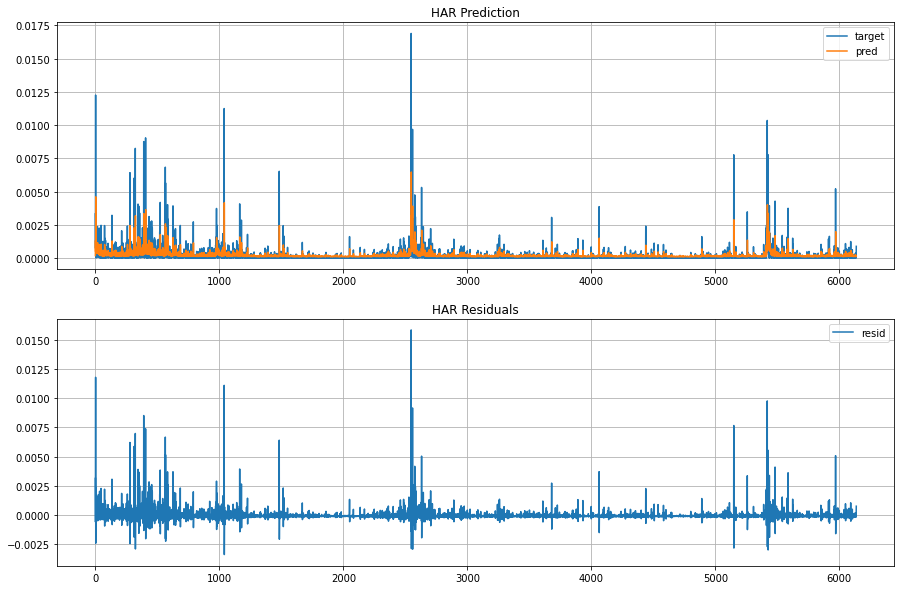

Estimating NN model ...
NN out-of-sample loss: 3.9771859405846044e-07
Predicted correlation: 0.3116604915828267


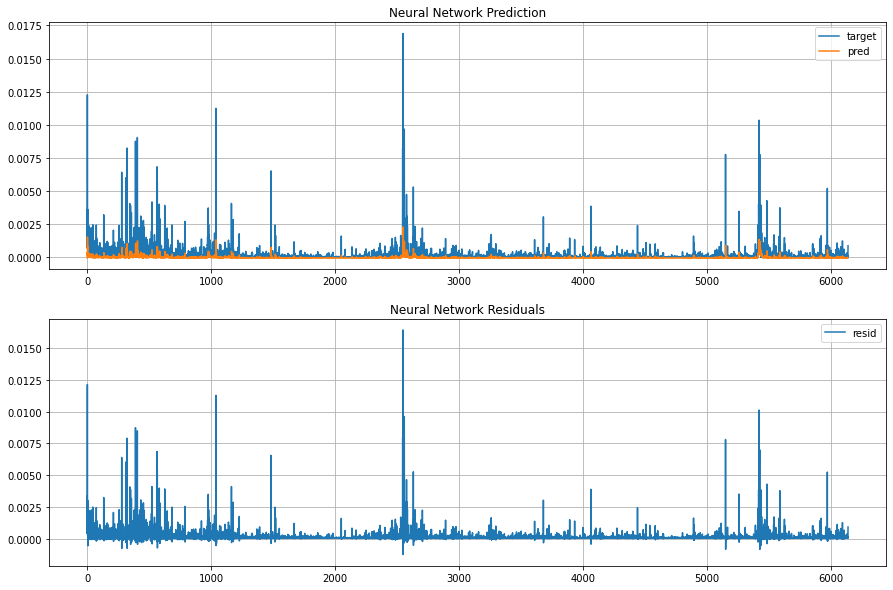

In [12]:
plot = True # plot for both models the true volatility versus the predicted one
normalize_features = False
use_own_config = True

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config:
        raise Exception()
except:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = 5
    hidden_layers = [2,]
    lr = .01


# the repeat what the features and targets used here are
features_har, features, targets # to train on
features_har_validation, features_validation, targets_validation # to validate on

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    features_train = features_har.copy(),
    features_validation = features_har_validation.copy(),
    targets_train = targets.copy(),
    targets_validation = targets_validation.copy(),
    normalize_features = False
)

print(f"HAR out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(output, targets_validation.reshape(-1,))[0,1]}")

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(targets_validation, label = "target")
    axs[0].plot(output, label = "pred")
    axs[1].plot(targets_validation.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")
data_train, data_test = DataSet(features.copy(), targets.copy()), DataSet(features_validation.copy(), targets_validation.copy())
loss, output = single_fit_and_evaluate_model(
    model = ForwardNeuralNetwork(features.shape[1], targets.shape[1], hidden_layers=hidden_layers),
    data_train = data_train,
    data_test = data_test,
    lr = lr,
    epochs = epochs,
    earlystopper = None,
    normalize_features = False,
    return_prediction = True
)

print(f"NN out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(targets_validation[:,0], output.detach().numpy()[:,0])[0,1]}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(targets_validation, label = "target")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[1].plot(targets_validation - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

In [10]:
ForwardNeuralNetwork(features.shape[1], targets.shape[1], hidden_layers=hidden_layers)

ForwardNeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)